# Importing libraries

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import layers

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report

In [3]:
import random as python_random
np.random.seed(42)
python_random.seed(42)
tf.random.set_seed(42)

# Importing dataset

In [4]:
train_dir = '../input/chest-xray-pneumonia/chest_xray/train/'
val_dir = '../input/chest-xray-pneumonia/chest_xray/val/'
test_dir = '../input/chest-xray-pneumonia/chest_xray/test/'

In [5]:
train_num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
train_num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
print(f"train_num_pneumonia: {train_num_pneumonia}")
print(f"train_num_normal: {train_num_normal}")

val_num_pneumonia = len(os.listdir(os.path.join(val_dir, 'PNEUMONIA')))
val_num_normal = len(os.listdir(os.path.join(val_dir, 'NORMAL')))
print(f"val_num_pneumonia: {val_num_pneumonia}")
print(f"val_num_normal: {val_num_normal}")

test_num_pneumonia = len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))
test_num_normal = len(os.listdir(os.path.join(test_dir, 'NORMAL')))
print(f"test_num_pneumonia: {test_num_pneumonia}")
print(f"test_num_normal: {test_num_normal}")

print("")
train_num = train_num_pneumonia+train_num_normal
val_num = val_num_pneumonia+val_num_normal
test_num = test_num_pneumonia+test_num_normal
print(f"train_num: {train_num}")
print(f"val_num: {val_num}")
print(f"test_num: {test_num}")

print("")
num_pneumonia = train_num_pneumonia + test_num_pneumonia + val_num_pneumonia
num_normal = train_num_normal + test_num_normal + val_num_normal
print(f"num_pneumonia: {num_pneumonia}")
print(f"num_normal: {num_normal}")

train_num_pneumonia: 3875
train_num_normal: 1341
val_num_pneumonia: 8
val_num_normal: 8
test_num_pneumonia: 390
test_num_normal: 234

train_num: 5216
val_num: 16
test_num: 624

num_pneumonia: 4273
num_normal: 1583


## Loading data function

In [6]:
labels = ["NORMAL", "PNEUMONIA"]
img_size = 224

def load_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
                
    return np.array(data, dtype="object")

## Loading data

In [7]:
train = load_data(train_dir)
test = load_data(test_dir)
val = load_data(val_dir)

## Splitting X and y

In [8]:
X_train = [] 
y_train = []
X_test = [] 
y_test = []
X_val = [] 
y_val = []

def split_x_y(data, x, y):
    for feature, label in data:
        x.append(feature)
        y.append(label)
    return np.array(x), np.array(y)

X_train, y_train = split_x_y(train, X_train, y_train)
X_test, y_test = split_x_y(test, X_test, y_test)
X_val, y_val = split_x_y(val, X_val, y_val)

# Data augmentation layer

In [9]:
def augmentation_layers(x):
    x = keras.layers.Rescaling(1./255)(x)
    x = keras.layers.RandomRotation(0.05)(x)
    return x

# Visualizing data

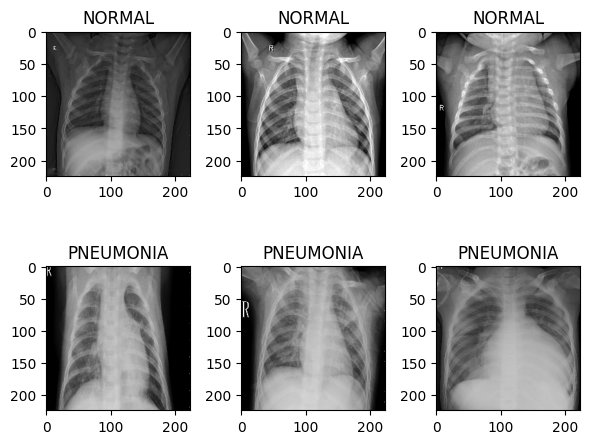

In [10]:
j=0
fig=plt.figure(figsize=(6, 6))
for i in (0,1,2,-2,-3,-4):
    fig.add_subplot(2,3,j+1)
    plt.imshow(train[i][0])
    plt.title(labels[train[i][1]])
    plt.tight_layout()
    j+=1
plt.show()

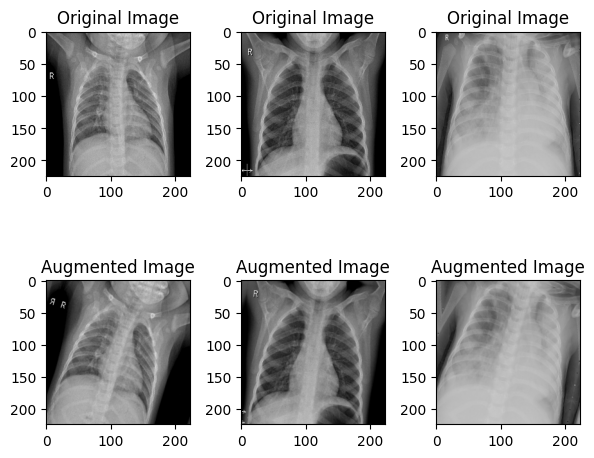

In [11]:
j=0
fig=plt.figure(figsize=(6, 6))
for i in (4,5,-1):
    fig.add_subplot(2,3,j+1)
    plt.imshow(train[i][0])
    plt.title("Original Image")
    x = augmentation_layers(train[i][0])
    fig.add_subplot(2,3,j+4)
    plt.imshow(x)
    plt.title("Augmented Image")
    plt.tight_layout()
    j+=1
plt.show()

# Calculating weights

In [12]:
weight_for_0 = num_pneumonia / (num_normal + num_pneumonia)
weight_for_1 = num_normal / (num_normal + num_pneumonia)

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for class 0: {weight_for_0:.2f}")
print(f"Weight for class 1: {weight_for_1:.2f}")

Weight for class 0: 0.73
Weight for class 1: 0.27


# Callbacks

In [13]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, verbose=1)

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, 
                                               mode='min')

# Metrics

In [14]:
def visualise_model_metrics(model, history):
    evaluation = model.evaluate(x=X_test,y=y_test)
    print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

    evaluation = model.evaluate(x=X_train,y=y_train)
    print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")
    
    plt.figure(figsize=(20,15))

    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'], label = "Training accuracy",marker='o')
    plt.plot(history.history['val_accuracy'], label="Validation accuracy",marker='o')
    plt.legend()
    plt.title("Training vs validation accuracy")


    plt.subplot(2,2,2)
    plt.plot(history.history['loss'], label = "Training loss",marker='o')
    plt.plot(history.history['val_loss'], label="Validation loss",marker='o')
    plt.legend()
    plt.title("Training vs validation loss")

    plt.show()

## Classification report function

In [15]:
def load_classification_report(y_pred):
    print('Classification report')
    print()
    print(classification_report(y_true=y_test,y_pred=y_pred, target_names=labels))

## Plotting ROC function

In [16]:
def plot_roc(y_pred):
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(fpr, tpr)

    plt.figure(figsize=(4, 4))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# ResNet50

In [17]:
base_resnet50 = tf.keras.applications.ResNet50(
                    include_top=False,
                    weights="imagenet",
                    input_shape=(224,224,3),
                    pooling='avg',
                    classes=1)

for layer in base_resnet50.layers:
        layer.trainable=False

94765736/94765736 [==============================] - 1s 0us/step


In [18]:
inputs = keras.layers.Input(shape=(224,224,3))

x = augmentation_layers(inputs)

x = base_resnet50(inputs)

x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512,activation='relu')(x)
x = layers.Dense(256,activation='relu')(x)
x = layers.Dense(128,activation='relu')(x)
x = layers.Dropout(0.5)(x)

predictions = layers.Dense(1,activation='sigmoid')(x)
resnet50 = keras.Model(inputs, predictions)

In [19]:
resnet50.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 3e-4),loss='binary_crossentropy',
                    metrics=['accuracy'])

In [20]:
checkpoint_resnet50 = '/kaggle/working/resnet50_weights.hdf5'

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_resnet50,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history_res50 = resnet50.fit(
    x=X_train, y=y_train, 
    epochs=30,
    validation_data=(X_val,y_val),
    class_weight=class_weight,
    callbacks = [reduce_lr, early_stopping, model_checkpoint],
    batch_size=32, validation_batch_size=8)

resnet50.load_weights(checkpoint_resnet50)

Epoch 1/30
163/163 [==============================] - 29s 101ms/step - loss: 0.0969 - accuracy: 0.8890 - val_loss: 0.4408 - val_accuracy: 0.8125 - lr: 3.0000e-04
Epoch 2/30
163/163 [==============================] - 15s 91ms/step - loss: 0.0595 - accuracy: 0.9387 - val_loss: 0.1632 - val_accuracy: 0.9375 - lr: 3.0000e-04
Epoch 3/30
163/163 [==============================] - 15s 92ms/step - loss: 0.0531 - accuracy: 0.9456 - val_loss: 0.1084 - val_accuracy: 1.0000 - lr: 3.0000e-04
Epoch 4/30
163/163 [==============================] - 15s 90ms/step - loss: 0.0476 - accuracy: 0.9523 - val_loss: 0.1479 - val_accuracy: 0.9375 - lr: 3.0000e-04
Epoch 5/30
163/163 [==============================] - 15s 94ms/step - loss: 0.0428 - accuracy: 0.9534 - val_loss: 0.0733 - val_accuracy: 1.0000 - lr: 3.0000e-04
Epoch 6/30
163/163 [==============================] - 15s 92ms/step - loss: 0.0478 - accuracy: 0.9515 - val_loss: 0.0886 - val_accuracy: 0.9375 - lr: 3.0000e-04
Epoch 7/30
163/163 [=============

20/20 [==============================] - 3s 119ms/step - loss: 0.2867 - accuracy: 0.8942
Test Accuracy: 89.42%
163/163 [==============================] - 15s 94ms/step - loss: 0.2229 - accuracy: 0.9099
Train Accuracy: 90.99%


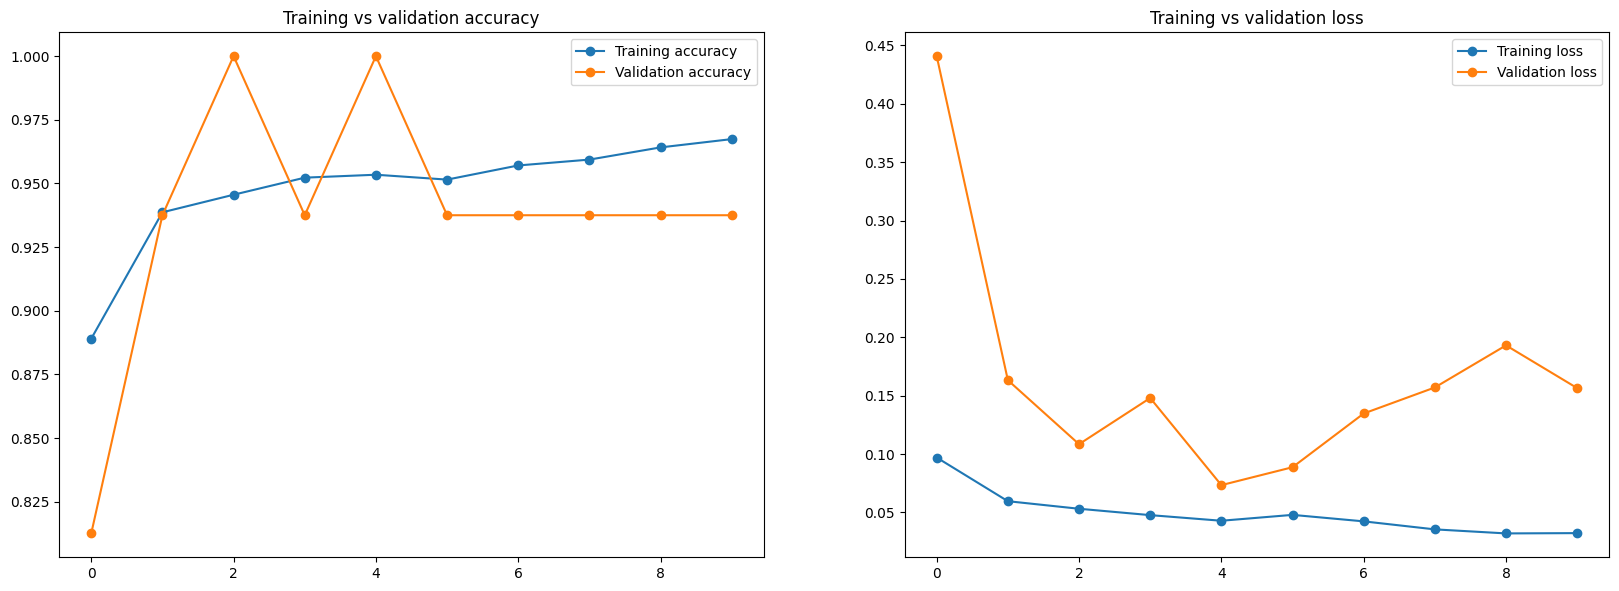

In [21]:
visualise_model_metrics(resnet50, history_res50)

20/20 [==============================] - 3s 94ms/step
Classification report

              precision    recall  f1-score   support

      NORMAL       0.86      0.85      0.86       234
   PNEUMONIA       0.91      0.92      0.92       390

    accuracy                           0.89       624
   macro avg       0.89      0.89      0.89       624
weighted avg       0.89      0.89      0.89       624



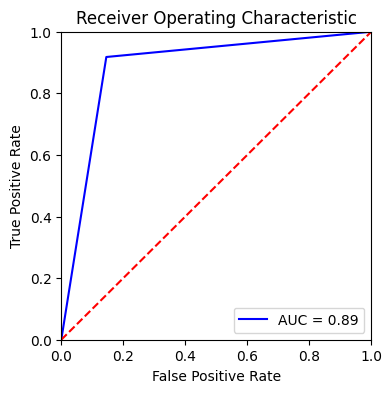

In [22]:
pred = resnet50.predict(X_test)
resnet50_pred = list(map(lambda x: 0 if x<0.5 else 1, pred))

load_classification_report(resnet50_pred)
plot_roc(resnet50_pred)

# DenseNet121

In [23]:
base_densenet121 = tf.keras.applications.DenseNet121(
                    include_top=False,
                    weights="imagenet",
                    input_shape=(224,224,3),
                    pooling='avg',
                    classes=1)

for layer in base_densenet121.layers:
        layer.trainable=False

29084464/29084464 [==============================] - 0s 0us/step


In [24]:
inputs = layers.Input(shape=(224,224,3))

x = augmentation_layers(inputs)

x = base_densenet121(inputs)

x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512,activation='relu')(x)
x = layers.Dense(256,activation='relu')(x)
x = layers.Dense(128,activation='relu')(x)
x = layers.Dropout(0.5)(x)

predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)
densenet121 = keras.Model(inputs, predictions)

In [25]:
densenet121.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 3e-4),loss='binary_crossentropy',
                    metrics=['accuracy'])

In [26]:
checkpoint_densenet121 = '/kaggle/working/densenet121_weights.hdf5'

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_densenet121,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history_densenet121 = densenet121.fit(
    x=X_train, y=y_train, 
    epochs=30,
    validation_data=(X_val,y_val),
    class_weight=class_weight,
    callbacks = [reduce_lr, early_stopping, model_checkpoint],
    batch_size=32, validation_batch_size=8)

densenet121.load_weights(checkpoint_densenet121)

Epoch 1/30
163/163 [==============================] - 27s 113ms/step - loss: 0.2604 - accuracy: 0.6994 - val_loss: 0.9008 - val_accuracy: 0.6875 - lr: 3.0000e-04
Epoch 2/30
163/163 [==============================] - 15s 95ms/step - loss: 0.1639 - accuracy: 0.8154 - val_loss: 0.7405 - val_accuracy: 0.7500 - lr: 3.0000e-04
Epoch 3/30
163/163 [==============================] - 15s 91ms/step - loss: 0.1355 - accuracy: 0.8491 - val_loss: 1.3179 - val_accuracy: 0.6250 - lr: 3.0000e-04
Epoch 4/30
163/163 [==============================] - ETA: 0s - loss: 0.1244 - accuracy: 0.8643
Epoch 4: ReduceLROnPlateau reducing learning rate to 6.000000284984708e-05.
163/163 [==============================] - 15s 91ms/step - loss: 0.1244 - accuracy: 0.8643 - val_loss: 1.2724 - val_accuracy: 0.6250 - lr: 3.0000e-04
Epoch 5/30
163/163 [==============================] - 15s 91ms/step - loss: 0.1139 - accuracy: 0.8794 - val_loss: 1.1183 - val_accuracy: 0.6875 - lr: 6.0000e-05
Epoch 6/30
163/163 [=============

20/20 [==============================] - 5s 147ms/step - loss: 0.4403 - accuracy: 0.8189
Test Accuracy: 81.89%
163/163 [==============================] - 15s 93ms/step - loss: 0.3919 - accuracy: 0.8497
Train Accuracy: 84.97%


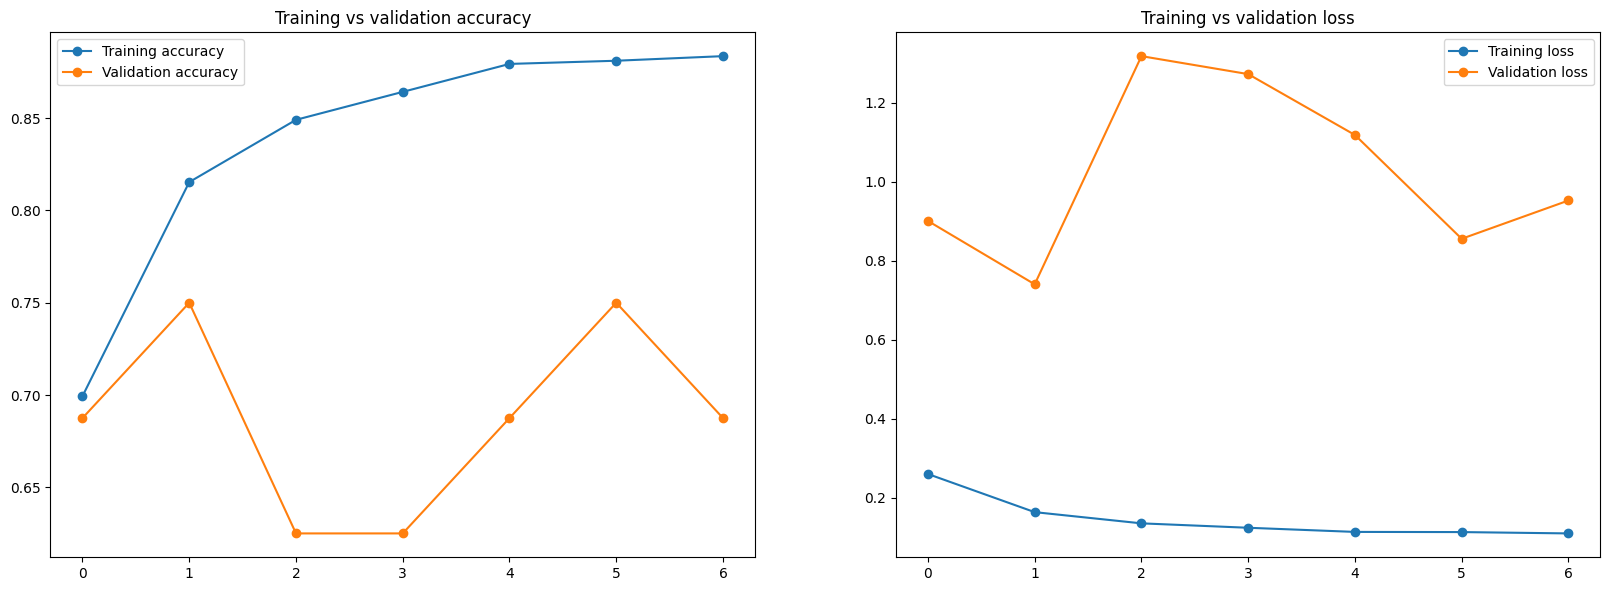

In [27]:
visualise_model_metrics(densenet121, history_densenet121)

20/20 [==============================] - 4s 90ms/step
Classification report

              precision    recall  f1-score   support

      NORMAL       0.73      0.83      0.77       234
   PNEUMONIA       0.89      0.81      0.85       390

    accuracy                           0.82       624
   macro avg       0.81      0.82      0.81       624
weighted avg       0.83      0.82      0.82       624



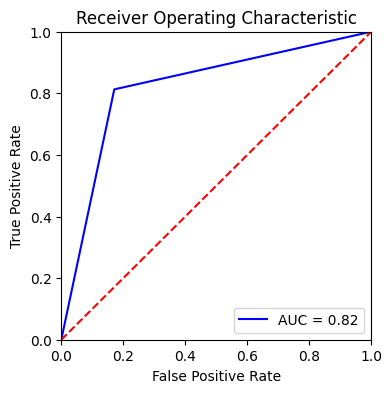

In [28]:
pred = densenet121.predict(X_test)
densenet121_pred = list(map(lambda x: 0 if x<0.5 else 1, pred))

load_classification_report(densenet121_pred)
plot_roc(densenet121_pred)

# MobileNetV2

In [33]:
mobilenet = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

mobilenet.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [49]:
inputs = tf.keras.Input(shape=(224,224,3))
pretrained_model = mobilenet(inputs, training=False)


x = tf.keras.layers.Conv2D(filters=32, kernel_size=(2, 2), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(units=200, activation='relu')(x)
x = tf.keras.layers.Dropout(rate=0.1)(x)


#outputs = tf.keras.layers.Dense(units=1, activation='sigmoid')(x)
#model = tf.keras.Model(inputs=inputs, outputs=outputs)
predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)
model = keras.Model(inputs, predictions)


print(model.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 223, 223, 32)      416       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 394272)            0         
                                                                 
 dense_10 (Dense)            (None, 200)               78854600  
                                                                 
 dropout_5 (Dropout)         (None, 200)               0         
                                                           

In [56]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 3e-4),loss='binary_crossentropy',
                    metrics=['accuracy'])

In [75]:


EPOCHS = 30

def lr_schedule(EPOCHS):
    lr = 0.001
    return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)

history = model.fit(
     x=X_train, y=y_train, 
    epochs=EPOCHS,
    validation_data=(X_val,y_val),
    class_weight=class_weight,
    callbacks = [ tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=50,
            restore_best_weights=True
        ),
        lr_callback],
    batch_size=32, validation_batch_size=8
)

Epoch 1/30
163/163 [==============================] - 9s 45ms/step - loss: 0.0314 - accuracy: 0.9937 - auc: 0.9946 - val_loss: 0.7779 - val_accuracy: 0.9375 - val_auc: 0.9375 - lr: 0.0010
Epoch 2/30
163/163 [==============================] - 6s 34ms/step - loss: 0.0072 - accuracy: 0.9985 - auc: 0.9991 - val_loss: 0.9663 - val_accuracy: 0.9375 - val_auc: 0.9375 - lr: 0.0010
Epoch 3/30
163/163 [==============================] - 6s 34ms/step - loss: 1.4937e-05 - accuracy: 1.0000 - auc: 1.0000 - val_loss: 1.8134 - val_accuracy: 0.9375 - val_auc: 0.9375 - lr: 0.0010
Epoch 4/30
163/163 [==============================] - 6s 34ms/step - loss: 0.0069 - accuracy: 0.9988 - auc: 0.9991 - val_loss: 1.0796 - val_accuracy: 0.9375 - val_auc: 0.9375 - lr: 0.0010
Epoch 5/30
163/163 [==============================] - 6s 38ms/step - loss: 0.1285 - accuracy: 0.9841 - auc: 0.9863 - val_loss: 1.0574e-34 - val_accuracy: 1.0000 - val_auc: 1.0000 - lr: 0.0010
Epoch 6/30
163/163 [==============================] 

20/20 [==============================] - 0s 10ms/step - loss: 14.5926 - accuracy: 0.7500 - auc: 0.6875
Test Accuracy: 75.00%
163/163 [==============================] - 2s 10ms/step - loss: 0.0794 - accuracy: 0.9937 - auc: 0.9975
Train Accuracy: 99.37%


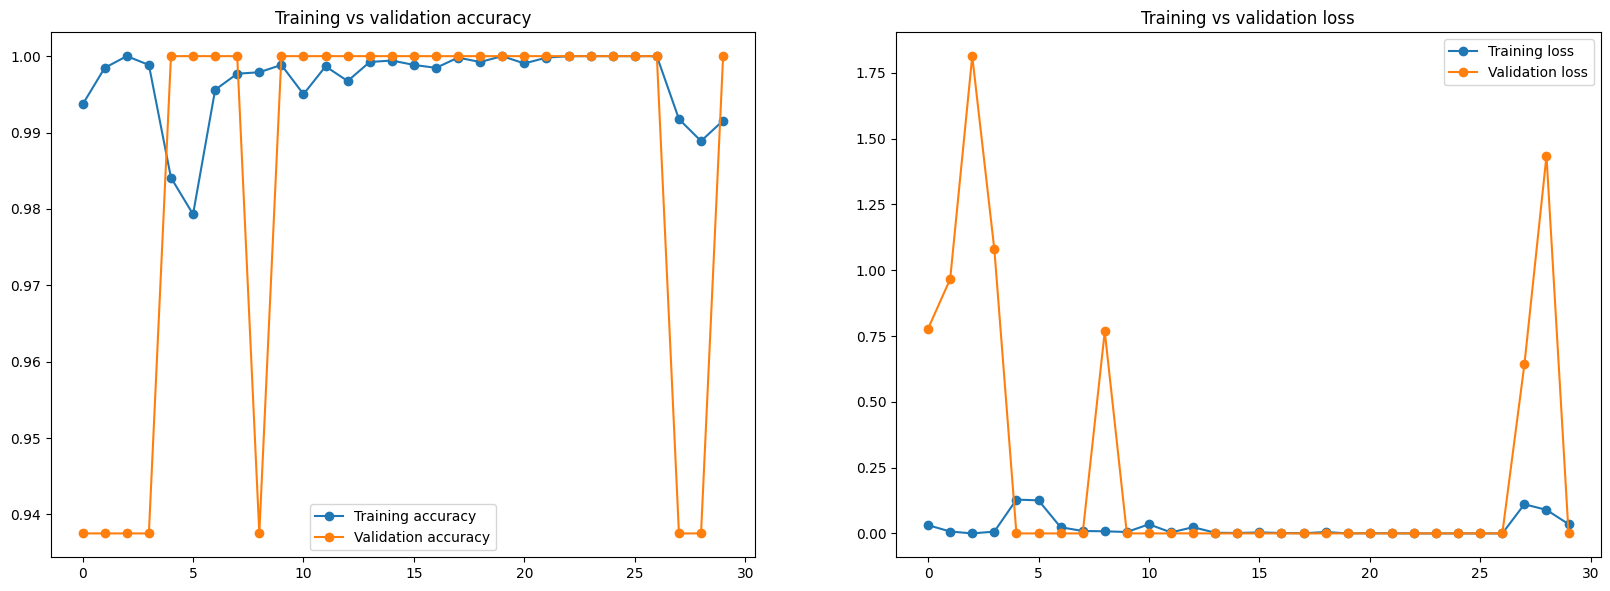

In [83]:
visualise_model_metrics(model, history)

20/20 [==============================] - 0s 8ms/step
Classification report

              precision    recall  f1-score   support

      NORMAL       0.92      0.36      0.52       234
   PNEUMONIA       0.72      0.98      0.83       390

    accuracy                           0.75       624
   macro avg       0.82      0.67      0.68       624
weighted avg       0.80      0.75      0.71       624



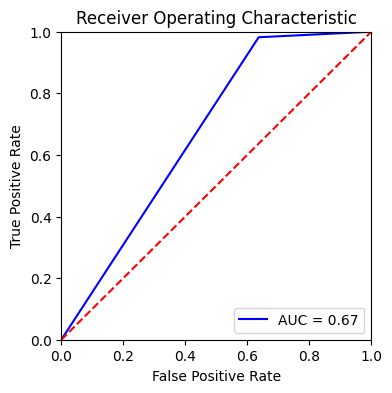

In [84]:
pred = model.predict(X_test)
mobilenetv2_pred = list(map(lambda x: 0 if x<0.5 else 1, pred))

load_classification_report(mobilenetv2_pred)
plot_roc(mobilenetv2_pred)

# InceptionV3

In [62]:
base_inceptionv3 = tf.keras.applications.InceptionV3(
                    include_top=False,
                    weights="imagenet",
                    input_shape=(224,224,3),
                    pooling='avg',
                    classes=1)
                    
for layer in base_inceptionv3.layers:
        layer.trainable=False

87910968/87910968 [==============================] - 0s 0us/step


In [64]:
inputs = layers.Input(shape=(224, 224, 3))

x = augmentation_layers(inputs)

x = base_inceptionv3(inputs)

x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512,activation='relu')(x)
x = layers.Dense(256,activation='relu')(x)
x = layers.Dense(128,activation='relu')(x)
x = layers.Dropout(0.5)(x)

predictions = tf.keras.layers.Dense(1,activation='sigmoid')(x)
inceptionv3 = keras.Model(inputs, predictions)

In [66]:
inceptionv3.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate= 0.001),loss='binary_crossentropy',
                    metrics=['accuracy'])

In [67]:
checkpoint_inceptionv3 = '/kaggle/working/inceptionv3_weights.hdf5'

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_inceptionv3,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

history_inceptionv3 = inceptionv3.fit(
    x=X_train, y=y_train, 
    epochs=30,
    validation_data=(X_val,y_val),
    class_weight=class_weight,
    callbacks = [reduce_lr, early_stopping, model_checkpoint],
    batch_size=32, validation_batch_size=8)

inceptionv3.load_weights(checkpoint_inceptionv3)

Epoch 1/30
163/163 [==============================] - 20s 86ms/step - loss: 1.3180 - accuracy: 0.7609 - val_loss: 5.4358 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 2/30
163/163 [==============================] - 12s 71ms/step - loss: 0.2104 - accuracy: 0.8073 - val_loss: 0.9453 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 3/30
163/163 [==============================] - 11s 69ms/step - loss: 0.1707 - accuracy: 0.8351 - val_loss: 3.4455 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/30
163/163 [==============================] - ETA: 0s - loss: 0.1673 - accuracy: 0.8407
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
163/163 [==============================] - 11s 68ms/step - loss: 0.1673 - accuracy: 0.8407 - val_loss: 2.2715 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 5/30
163/163 [==============================] - 11s 67ms/step - loss: 0.1214 - accuracy: 0.8712 - val_loss: 1.3531 - val_accuracy: 0.6875 - lr: 2.0000e-04
Epoch 6/30
163/163 [=============================

20/20 [==============================] - 4s 115ms/step - loss: 0.3244 - accuracy: 0.8590
Test Accuracy: 85.90%
163/163 [==============================] - 11s 67ms/step - loss: 0.2471 - accuracy: 0.8972
Train Accuracy: 89.72%


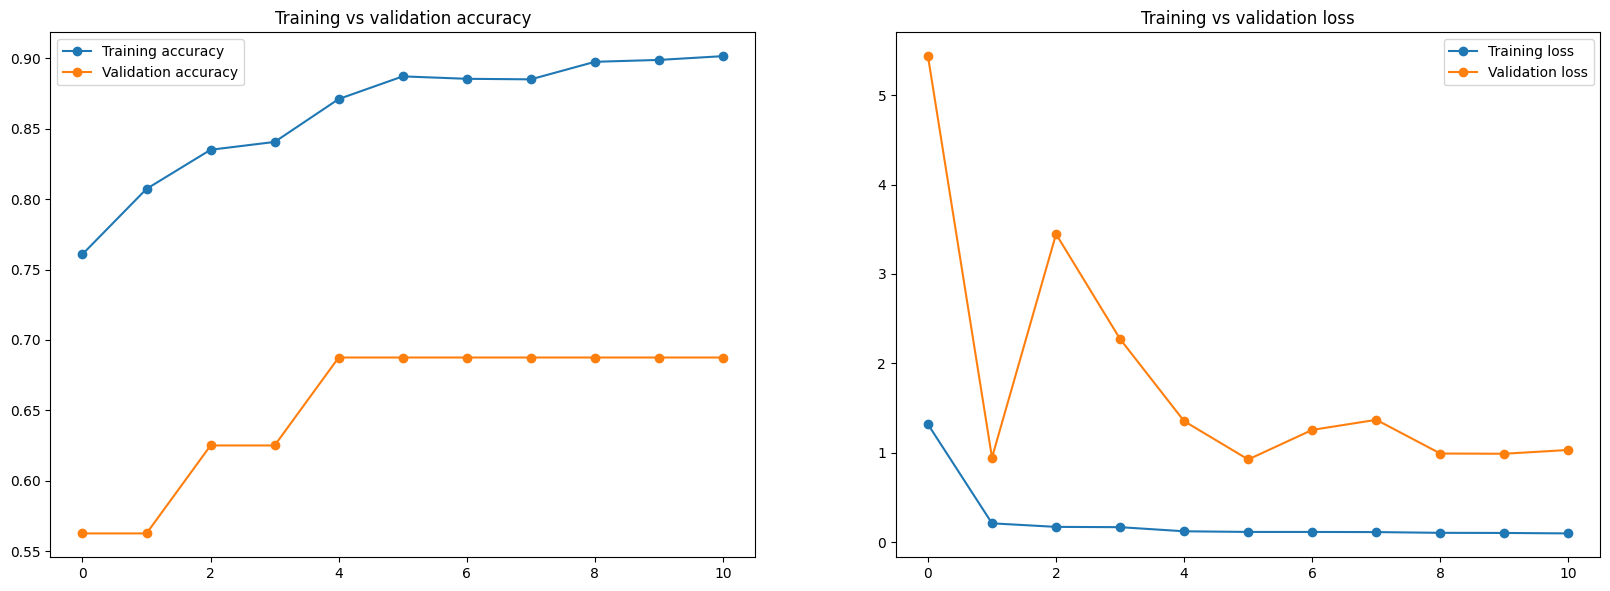

In [68]:
visualise_model_metrics(inceptionv3, history_inceptionv3)

20/20 [==============================] - 3s 67ms/step
Classification report

              precision    recall  f1-score   support

      NORMAL       0.81      0.82      0.81       234
   PNEUMONIA       0.89      0.88      0.89       390

    accuracy                           0.86       624
   macro avg       0.85      0.85      0.85       624
weighted avg       0.86      0.86      0.86       624



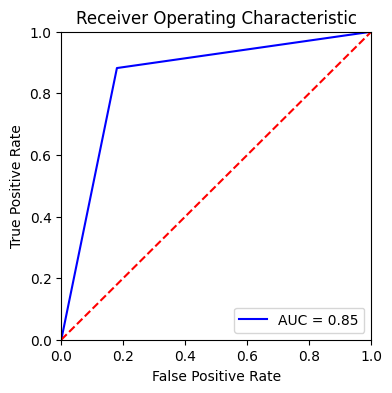

In [69]:
pred = inceptionv3.predict(X_test)
inceptionv3_pred = list(map(lambda x: 0 if x<0.5 else 1, pred))

load_classification_report(inceptionv3_pred)
plot_roc(inceptionv3_pred)

# Metrics comparison

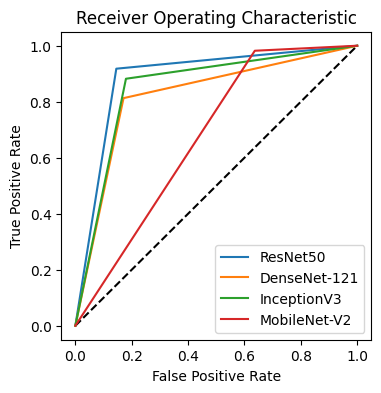

In [85]:
fpr1, tpr1, thresholds1 = roc_curve(y_test, resnet50_pred)
fpr4, tpr4, thresholds4 = roc_curve(y_test, densenet121_pred)
fpr5, tpr5, thresholds5 = roc_curve(y_test, inceptionv3_pred)
fpr6, tpr6, thresholds6 = roc_curve(y_test, mobilenetv2_pred)


plt.figure(figsize=(4, 4))
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "ResNet50")
plt.plot(fpr4, tpr4, label= "DenseNet-121")
plt.plot(fpr5, tpr5, label= "InceptionV3")
plt.plot(fpr6, tpr6, label= "MobileNet-V2")

plt.legend(loc = 'lower right')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('Receiver Operating Characteristic')
plt.show()

In [86]:
def print_scores(y_pred):    
    accuracy  = accuracy_score(y_test, y_pred)
    precision  = precision_score(y_test, y_pred)
    recall  = recall_score( y_test, y_pred)
    f1  = f1_score(y_test, y_pred)
    roc  = roc_auc_score(y_test, y_pred)
    print("Accuarcy Score: ", format(accuracy*100, '.2f'))
    print("Precision Score: ", format(precision*100, '.2f'))
    print("Recall Score: ", format(recall*100, '.2f'))
    print("F1 Score: ", format(f1*100, '.2f'))
    print("ROC AUC Score: ", format(roc*100, '.2f'))
    print("")

In [87]:
print("ResNet50")
print_scores(resnet50_pred)
print("DenseNet-121")
print_scores(densenet121_pred)
print("Inception-V3")
print_scores(inceptionv3_pred)
print("MobileNet-V2")
print_scores(mobilenetv2_pred)

ResNet50
Accuarcy Score:  89.42
Precision Score:  91.33
Recall Score:  91.79
F1 Score:  91.56
ROC AUC Score:  88.63

DenseNet-121
Accuarcy Score:  81.89
Precision Score:  88.80
Recall Score:  81.28
F1 Score:  84.87
ROC AUC Score:  82.09

Inception-V3
Accuarcy Score:  85.90
Precision Score:  89.12
Recall Score:  88.21
F1 Score:  88.66
ROC AUC Score:  85.13

MobileNet-V2
Accuarcy Score:  75.00
Precision Score:  71.99
Recall Score:  98.21
F1 Score:  83.08
ROC AUC Score:  67.26

